<a href="https://colab.research.google.com/github/Amadou794545/Simulation-d-emploi-en-science-des-donnees-chez-British-Airways-sur-Forage/blob/main/Simulation_d'emploi_en_science_des_donn%C3%A9es_chez_British_Airways_sur_Forage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [ ]:
df = pd.read_csv("/content/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [ ]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [ ]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [ ]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [ ]:
df.flight_day=df.flight_day.astype("object")

In [ ]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [ ]:
#voir le nombre de doublon
lignes_doublons = df[df.duplicated(keep=False)]

In [ ]:
lignes_doublons

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
115,1,Internet,RoundTrip,65,278,2,4,AKLKUL,Malaysia,0,0,0,8.83,0
117,1,Internet,RoundTrip,263,58,4,7,AKLKUL,Malaysia,0,1,0,8.83,0
122,1,Internet,RoundTrip,42,17,14,2,AKLKUL,Malaysia,0,0,0,8.83,1
135,4,Internet,RoundTrip,366,17,16,7,AKLKUL,Malaysia,1,0,1,8.83,0
177,5,Internet,RoundTrip,206,17,13,7,AKLKUL,Malaysia,1,0,0,8.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49905,1,Internet,RoundTrip,2,6,3,4,PENTPE,Malaysia,0,0,1,4.67,0
49911,1,Internet,RoundTrip,30,6,7,4,PENTPE,Taiwan,0,0,0,4.67,0
49934,1,Internet,RoundTrip,2,6,3,4,PENTPE,Malaysia,0,0,1,4.67,0
49944,1,Internet,RoundTrip,2,6,3,4,PENTPE,Malaysia,0,0,1,4.67,0


In [ ]:
df = df.drop_duplicates()

# Analyse des variables categoriel


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49281 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49281 non-null  int64  
 1   sales_channel          49281 non-null  object 
 2   trip_type              49281 non-null  object 
 3   purchase_lead          49281 non-null  int64  
 4   length_of_stay         49281 non-null  int64  
 5   flight_hour            49281 non-null  int64  
 6   flight_day             49281 non-null  object 
 7   route                  49281 non-null  object 
 8   booking_origin         49281 non-null  object 
 9   wants_extra_baggage    49281 non-null  int64  
 10  wants_preferred_seat   49281 non-null  int64  
 11  wants_in_flight_meals  49281 non-null  int64  
 12  flight_duration        49281 non-null  float64
 13  booking_complete       49281 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.6+ MB


In [ ]:
df.sales_channel.value_counts()

,count
sales_channel,
Internet,43917
Mobile,5364


In [ ]:
df[df["sales_channel"] == "Mobile"]["booking_complete"].value_counts(normalize=True) * 100

,proportion
booking_complete,
0,89.019389
1,10.980611


In [ ]:
def analyse_auto_categorielle(df):
    """
    Détecte, nettoie et analyse toutes les colonnes catégorielles d'un DataFrame.
    """
    # 1. Sélection automatique des colonnes de type 'object' ou 'category'
    colonnes_cat = df.select_dtypes(include=['object', 'category']).columns

    if len(colonnes_cat) == 0:
        print("Aucune colonne catégorielle détectée.")
        return

    print(f"🔍 Analyse lancée sur {len(colonnes_cat)} colonnes : {list(colonnes_cat)}\n")

    for col in colonnes_cat:
        print(f"--- ANALYSE : {col.upper()} ---")

        # 2. Nettoyage préventif (Espaces et Uniformisation)
        df[col] = df[col].astype(str).str.strip().str.capitalize()

        # 3. Calcul des statistiques
        counts = df[col].value_counts(dropna=False)
        percent = df[col].value_counts(dropna=False, normalize=True) * 100

        stats = pd.DataFrame({
            'Effectif': counts,
            'Pourcentage (%)': percent.round(2)
        })

        print(stats)
        print(f"\nNombre de valeurs uniques : {df[col].nunique()}")
        print(f"Valeurs manquantes (NaN) : {df[col].isna().sum() or 'Aucune'}")

        # 4. Visualisation
        plt.figure(figsize=(10, 5))
        # On limite à 15 barres max pour que le graphique reste lisible
        sns.countplot(data=df, x=col, order=counts.index[:15], palette='magma')
        plt.title(f"Top 15 - Distribution de {col}")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

        print("-" * 50 + "\n")

🔍 Analyse lancée sur 5 colonnes : ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']

--- ANALYSE : SALES_CHANNEL ---
               Effectif  Pourcentage (%)
sales_channel                           
Internet          43917            89.12
Mobile             5364            10.88

Nombre de valeurs uniques : 2
Valeurs manquantes (NaN) : Aucune


/tmp/ipython-input-383011240.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=counts.index[:15], palette='magma')


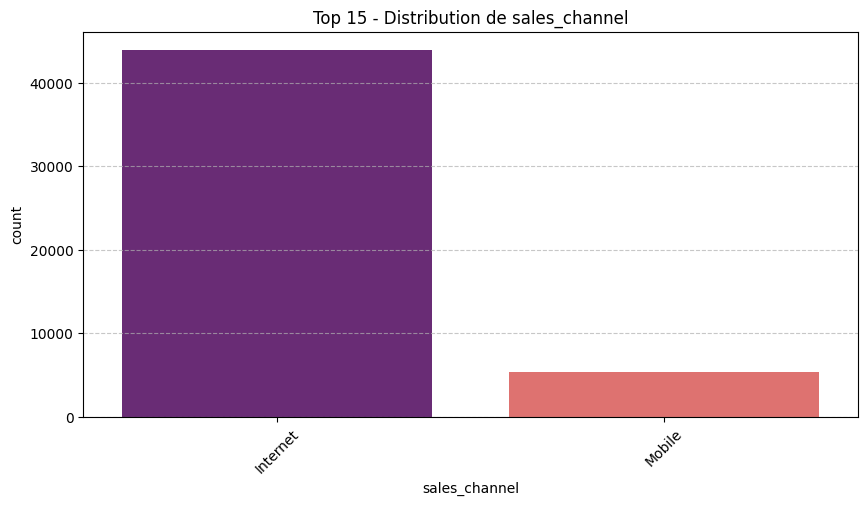

--------------------------------------------------

--- ANALYSE : TRIP_TYPE ---
            Effectif  Pourcentage (%)
trip_type                            
Roundtrip      48779            98.98
Oneway           386             0.78
Circletrip       116             0.24

Nombre de valeurs uniques : 3
Valeurs manquantes (NaN) : Aucune


/tmp/ipython-input-383011240.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=counts.index[:15], palette='magma')


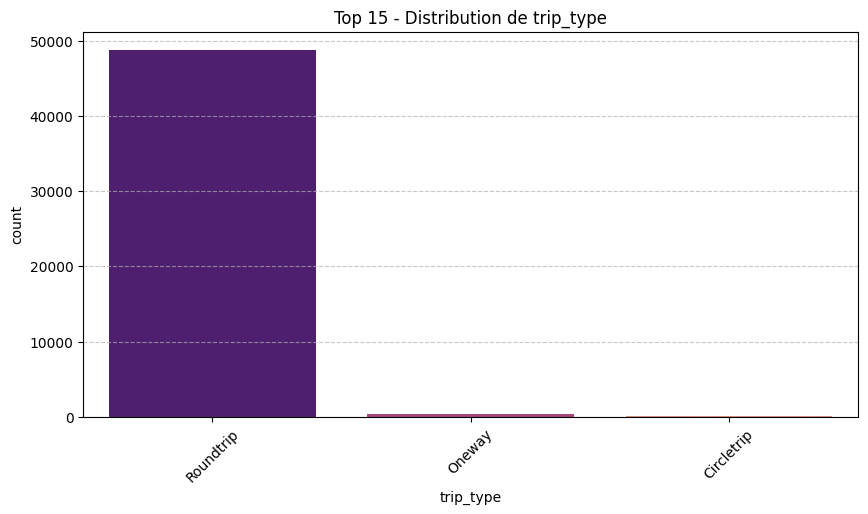

--------------------------------------------------

--- ANALYSE : FLIGHT_DAY ---
            Effectif  Pourcentage (%)
flight_day                           
1               7988            16.21
3               7562            15.34
2               7558            15.34
4               7323            14.86
5               6685            13.57
7               6442            13.07
6               5723            11.61

Nombre de valeurs uniques : 7
Valeurs manquantes (NaN) : Aucune


/tmp/ipython-input-383011240.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=counts.index[:15], palette='magma')


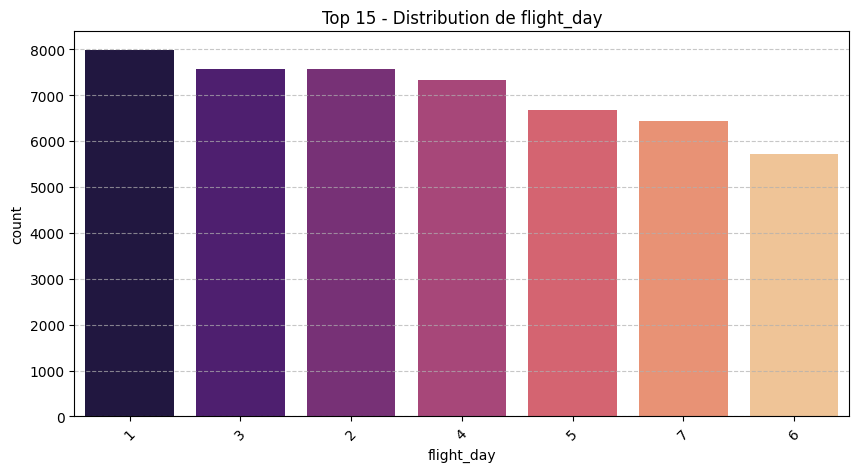

--------------------------------------------------

--- ANALYSE : ROUTE ---
        Effectif  Pourcentage (%)
route                            
Aklkul      2620             5.32
Pentpe       912             1.85
Melsgn       833             1.69
Icnsin       793             1.61
Dmkkix       729             1.48
...          ...              ...
Ckgkno         1             0.00
Kbrwuh         1             0.00
Jedmfm         1             0.00
Ktmtwu         1             0.00
Mruxiy         1             0.00

[799 rows x 2 columns]

Nombre de valeurs uniques : 799
Valeurs manquantes (NaN) : Aucune


/tmp/ipython-input-383011240.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=counts.index[:15], palette='magma')


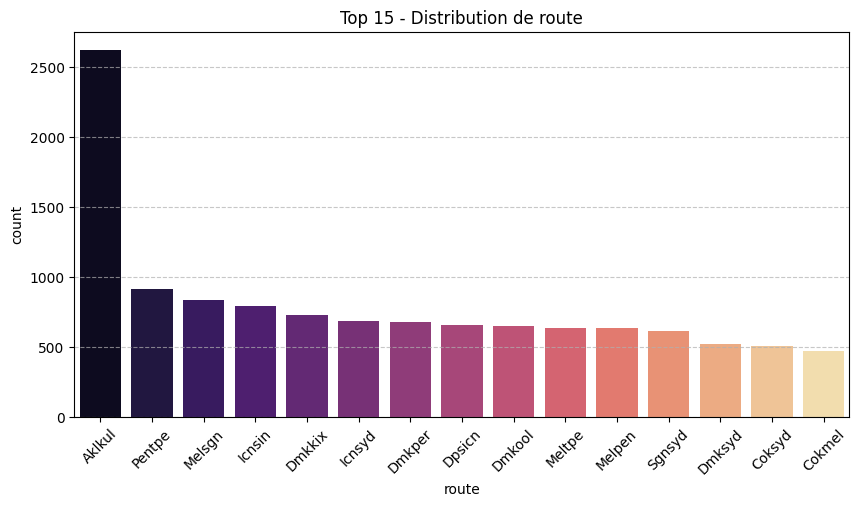

--------------------------------------------------

--- ANALYSE : BOOKING_ORIGIN ---
                      Effectif  Pourcentage (%)
booking_origin                                 
Australia                17691            35.90
Malaysia                  7055            14.32
South korea               4502             9.14
Japan                     3819             7.75
China                     3284             6.66
...                        ...              ...
Ghana                        1             0.00
Gibraltar                    1             0.00
Guatemala                    1             0.00
Algeria                      1             0.00
Svalbard & jan mayen         1             0.00

[104 rows x 2 columns]

Nombre de valeurs uniques : 104
Valeurs manquantes (NaN) : Aucune


/tmp/ipython-input-383011240.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=counts.index[:15], palette='magma')


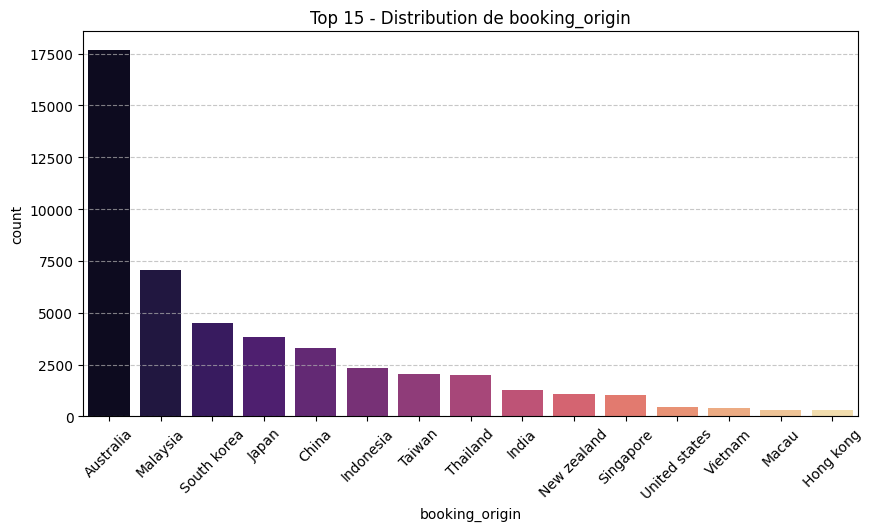

--------------------------------------------------



In [ ]:
analyse_auto_categorielle(df)

In [ ]:
def analyse_auto_bivariee(df):
    """
    Analyse les relations entre toutes les variables catégorielles d'un dataset.
    Tableaux de contingence, Test du Chi-deux et Heatmaps.
    """
    # 1. Sélection des colonnes catégorielles
    cols = df.select_dtypes(include=['object', 'category']).columns

    if len(cols) < 2:
        print("Il faut au moins 2 colonnes catégorielles pour une analyse bivariée.")
        return

    # 2. Boucle sur les paires de colonnes (sans doublons)
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            col1, col2 = cols[i], cols[j]

            print(f"\n=== RELATION : {col1.upper()} vs {col2.upper()} ===")

            # 3. Tableau de contingence (Fréquences croisées)
            contingency_table = pd.crosstab(df[col1], df[col2])

            # 4. Test statistique du Chi-deux
            # On vérifie s'il y a une dépendance statistique
            stat, p, dof, expected = chi2_contingency(contingency_table)

            print(f"P-Value du test Chi-deux : {p:.4f}")
            if p < 0.05:
                print("✅ Résultat : Il existe une relation statistiquement significative.")
            else:
                print("❌ Résultat : Pas de relation significative (indépendance).")

            # 5. Visualisation (Heatmap)
            plt.figure(figsize=(10, 6))
            sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
            plt.title(f"Répartition : {col1} en fonction de {col2}")
            plt.show()

            print("-" * 50)


=== RELATION : SALES_CHANNEL vs TRIP_TYPE ===
P-Value du test Chi-deux : 0.0000
✅ Résultat : Il existe une relation statistiquement significative.


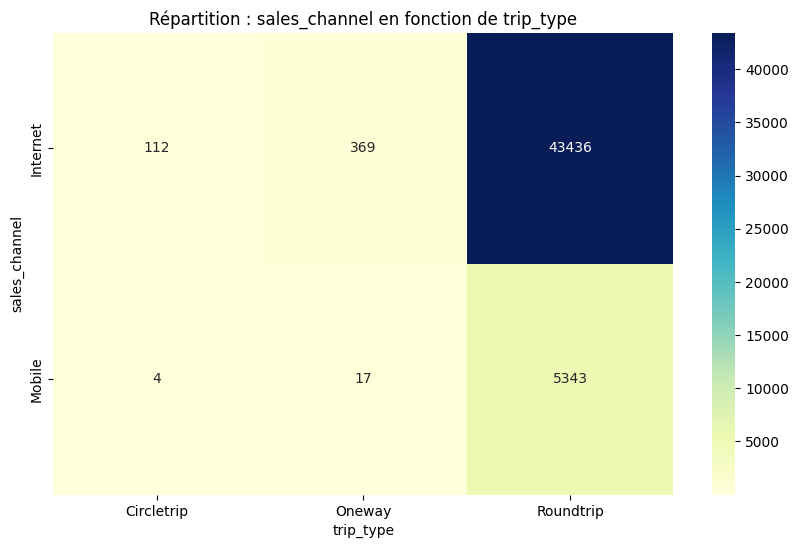

--------------------------------------------------

=== RELATION : SALES_CHANNEL vs FLIGHT_DAY ===
P-Value du test Chi-deux : 0.0000
✅ Résultat : Il existe une relation statistiquement significative.


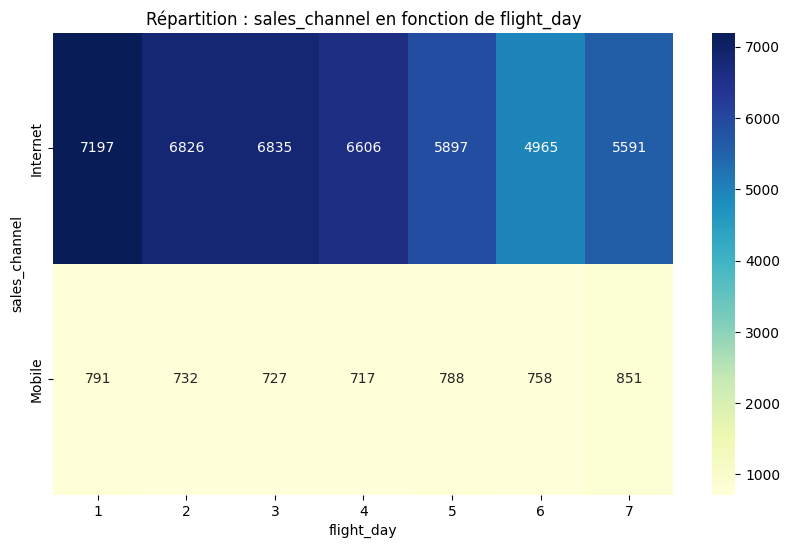

--------------------------------------------------

=== RELATION : SALES_CHANNEL vs ROUTE ===
P-Value du test Chi-deux : 0.0000
✅ Résultat : Il existe une relation statistiquement significative.


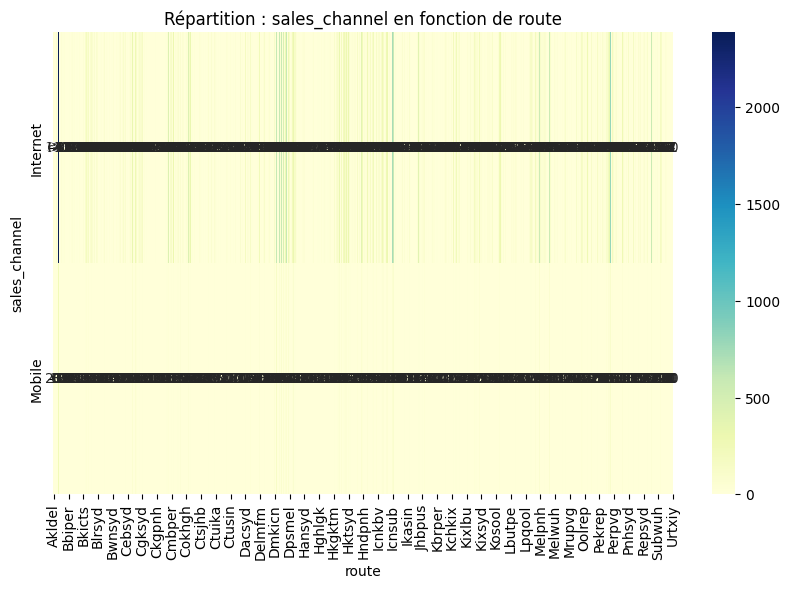

--------------------------------------------------

=== RELATION : SALES_CHANNEL vs BOOKING_ORIGIN ===
P-Value du test Chi-deux : 0.0000
✅ Résultat : Il existe une relation statistiquement significative.


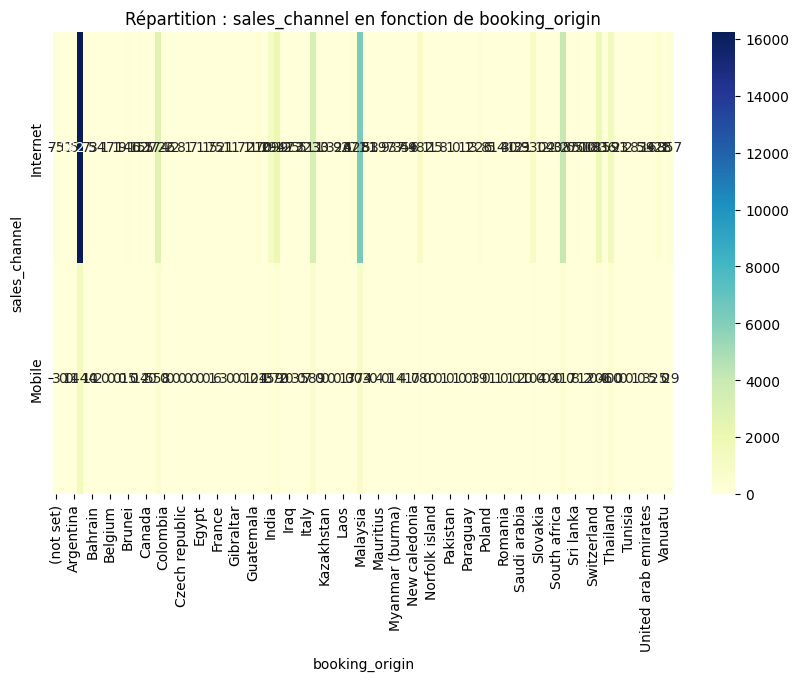

--------------------------------------------------

=== RELATION : TRIP_TYPE vs FLIGHT_DAY ===
P-Value du test Chi-deux : 0.4204
❌ Résultat : Pas de relation significative (indépendance).


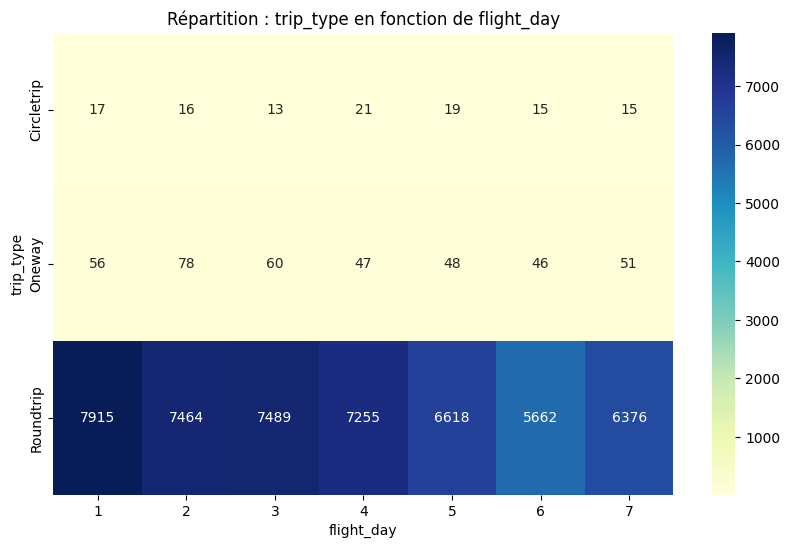

--------------------------------------------------

=== RELATION : TRIP_TYPE vs ROUTE ===
P-Value du test Chi-deux : 0.0000
✅ Résultat : Il existe une relation statistiquement significative.


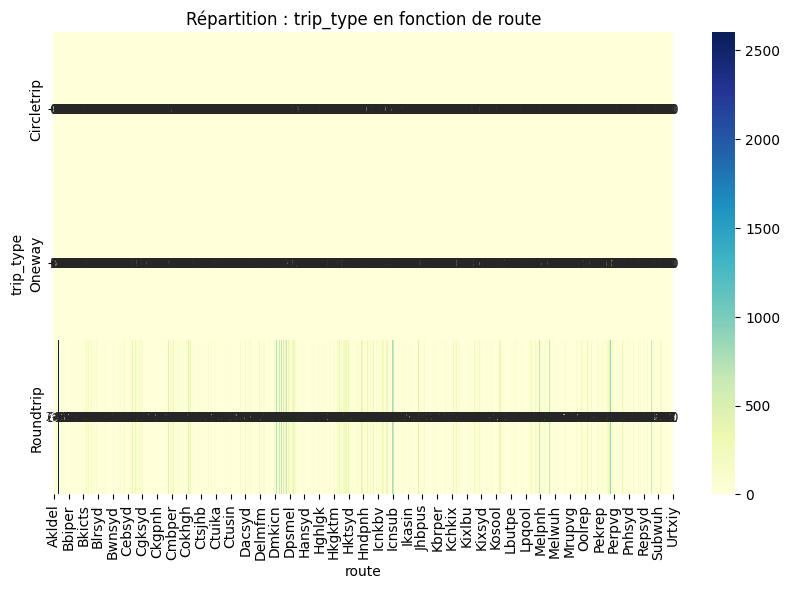

--------------------------------------------------

=== RELATION : TRIP_TYPE vs BOOKING_ORIGIN ===
P-Value du test Chi-deux : 0.0000
✅ Résultat : Il existe une relation statistiquement significative.


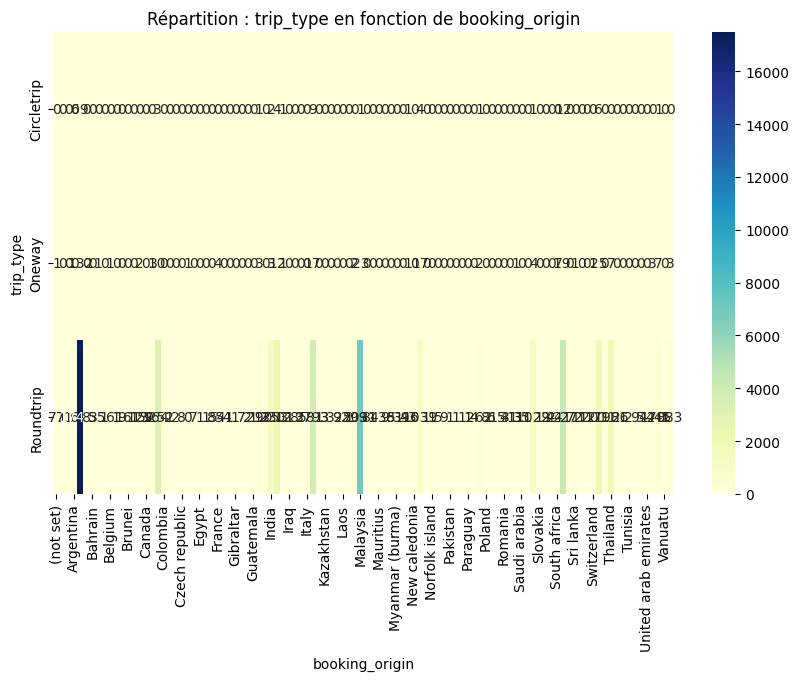

--------------------------------------------------

=== RELATION : FLIGHT_DAY vs ROUTE ===
P-Value du test Chi-deux : 0.0000
✅ Résultat : Il existe une relation statistiquement significative.


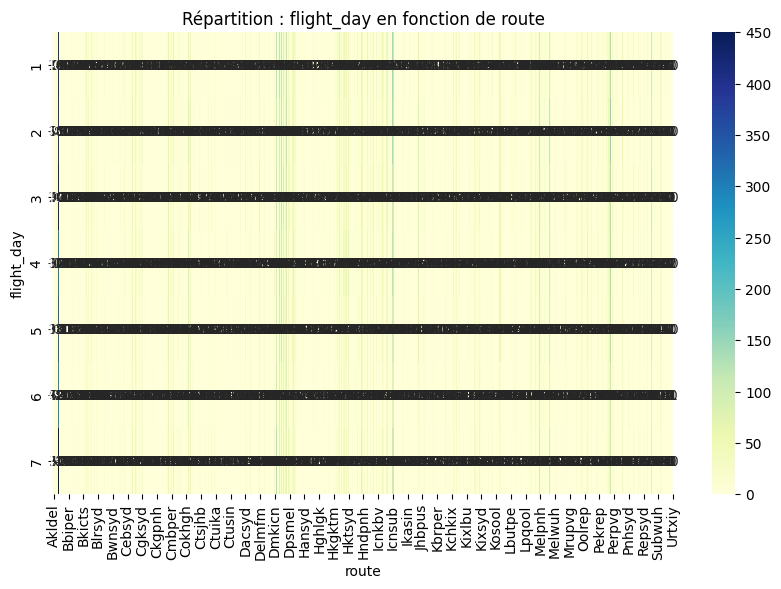

--------------------------------------------------

=== RELATION : FLIGHT_DAY vs BOOKING_ORIGIN ===
P-Value du test Chi-deux : 0.0000
✅ Résultat : Il existe une relation statistiquement significative.


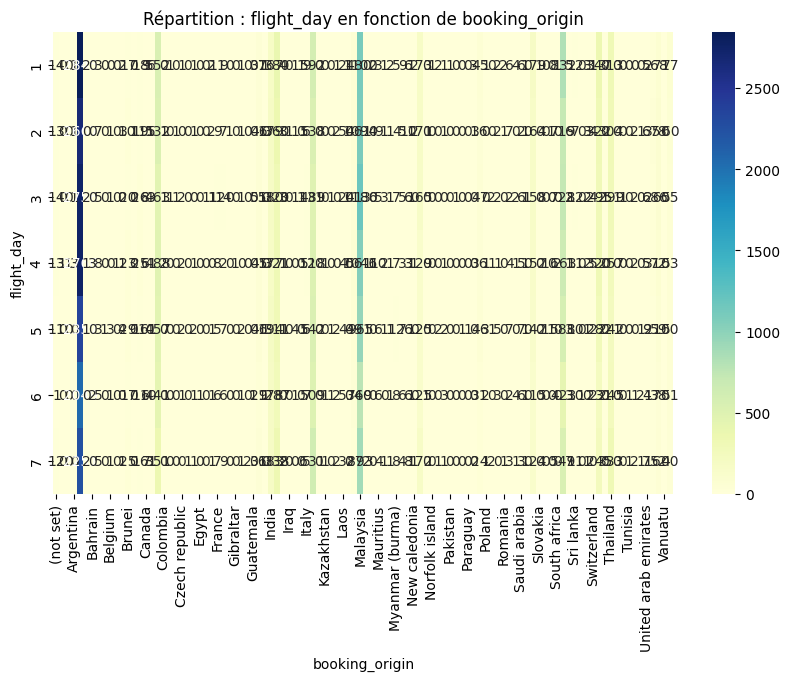

--------------------------------------------------

=== RELATION : ROUTE vs BOOKING_ORIGIN ===
P-Value du test Chi-deux : 0.0000
✅ Résultat : Il existe une relation statistiquement significative.


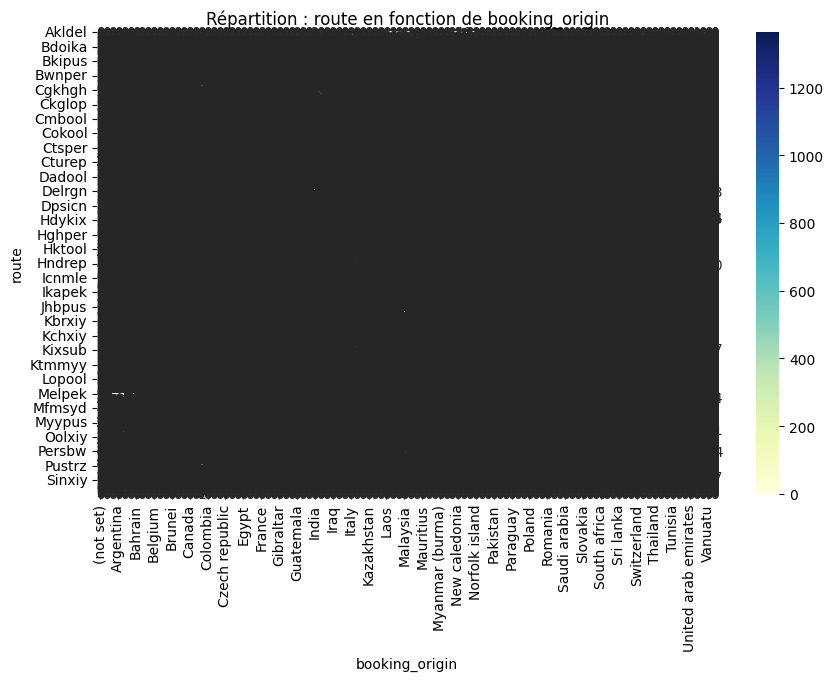

--------------------------------------------------


In [ ]:
analyse_auto_bivariee(df)

# Analyse des colonnes numérique

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyse_auto_numerique(df):
    """
    Analyse automatique des colonnes numériques : stats, distribution et outliers.
    """
    # Sélection des colonnes numériques (int et float)
    cols_num = df.select_dtypes(include=['number']).columns

    if len(cols_num) == 0:
        print("Aucune colonne numérique détectée.")
        return

    for col in cols_num:
        print(f"\n=== ANALYSE NUMÉRIQUE : {col.upper()} ===")

        # 1. Statistiques descriptives
        desc = df[col].describe()
        skew = df[col].skew()
        print(desc)
        print(f"Asymétrie (Skewness) : {skew:.2f}")
        print(f"Valeurs manquantes : {df[col].isna().sum()}")

        # 2. Visualisation (Double graphique)
        fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
                                              gridspec_kw={"height_ratios": (.15, .85)},
                                              figsize=(10, 6))

        # Boîte à moustaches (Boxplot) pour voir les outliers
        sns.boxplot(data=df, x=col, ax=ax_box, color="skyblue")
        ax_box.set(xlabel='')

        # Histogramme avec courbe de densité (KDE)
        sns.histplot(data=df, x=col, ax=ax_hist, kde=True, color="navy")

        plt.title(f"Distribution et Outliers de {col}")
        plt.show()
        print("-" * 50)

# Utilisation : analyse_auto_numerique(votre_df)


=== ANALYSE NUMÉRIQUE : NUM_PASSENGERS ===
count    49281.000000
mean         1.590187
std          1.016538
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: num_passengers, dtype: float64
Asymétrie (Skewness) : 2.69
Valeurs manquantes : 0


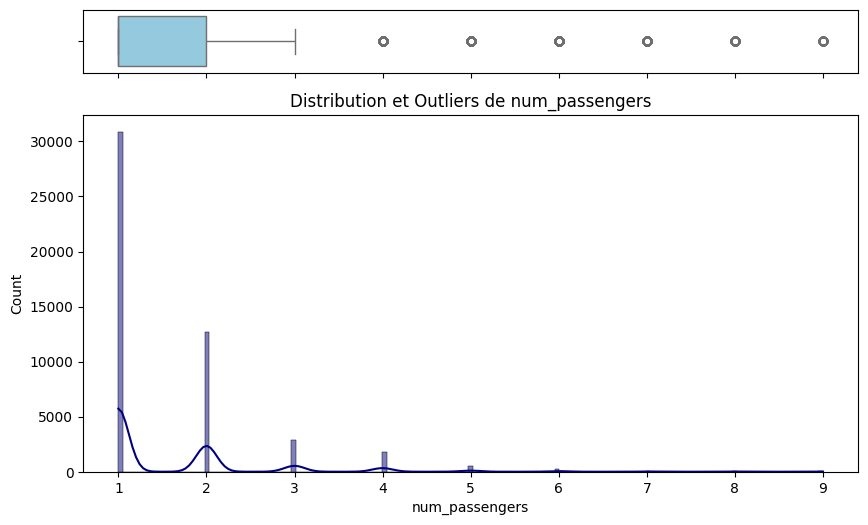

--------------------------------------------------

=== ANALYSE NUMÉRIQUE : PURCHASE_LEAD ===
count    49281.000000
mean        84.723281
std         90.410229
min          0.000000
25%         21.000000
50%         51.000000
75%        115.000000
max        867.000000
Name: purchase_lead, dtype: float64
Asymétrie (Skewness) : 1.66
Valeurs manquantes : 0


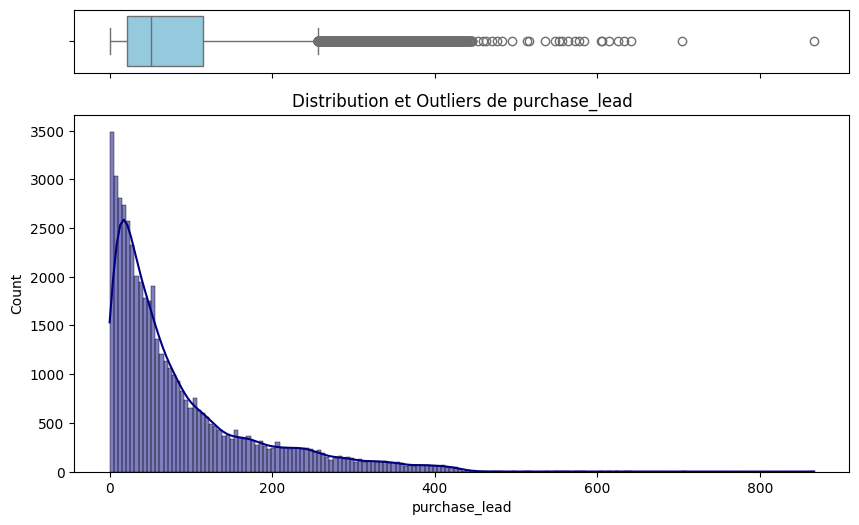

--------------------------------------------------

=== ANALYSE NUMÉRIQUE : LENGTH_OF_STAY ===
count    49281.000000
mean        23.053976
std         33.832149
min          0.000000
25%          5.000000
50%         17.000000
75%         28.000000
max        778.000000
Name: length_of_stay, dtype: float64
Asymétrie (Skewness) : 5.30
Valeurs manquantes : 0


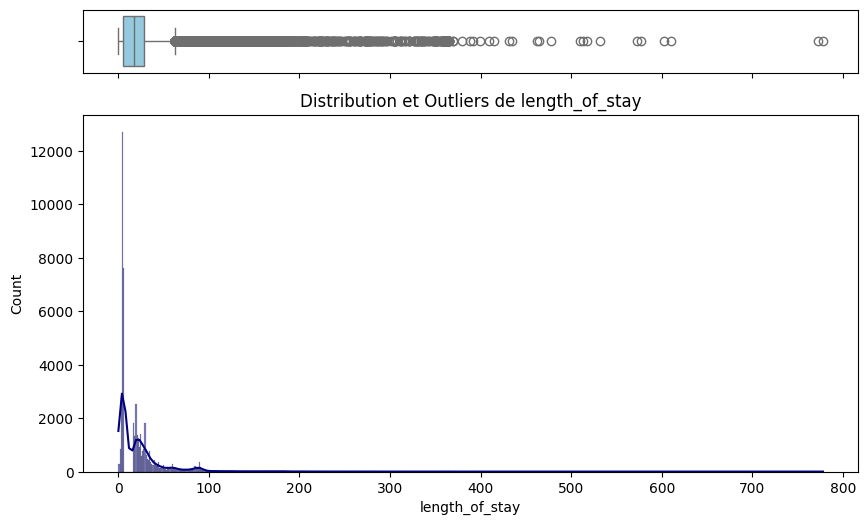

--------------------------------------------------

=== ANALYSE NUMÉRIQUE : FLIGHT_HOUR ===
count    49281.000000
mean         9.070676
std          5.413099
min          0.000000
25%          5.000000
50%          9.000000
75%         13.000000
max         23.000000
Name: flight_hour, dtype: float64
Asymétrie (Skewness) : 0.40
Valeurs manquantes : 0


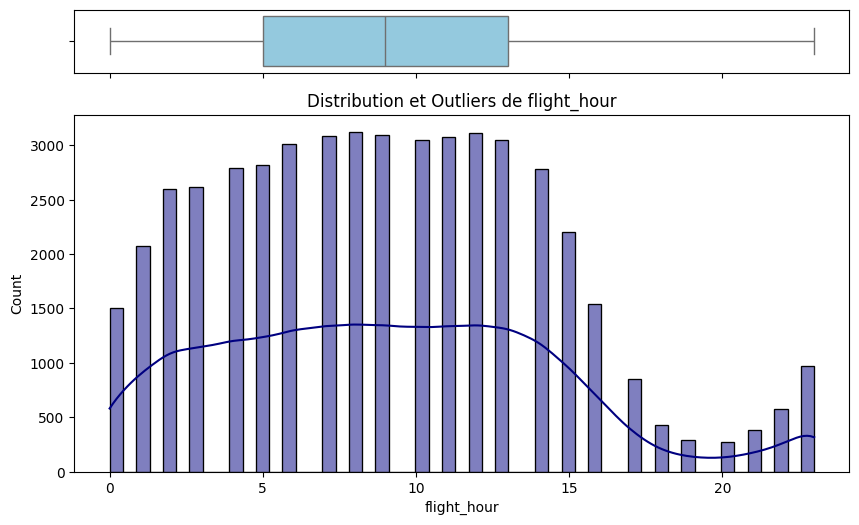

--------------------------------------------------

=== ANALYSE NUMÉRIQUE : WANTS_EXTRA_BAGGAGE ===
count    49281.000000
mean         0.668229
std          0.470854
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: wants_extra_baggage, dtype: float64
Asymétrie (Skewness) : -0.71
Valeurs manquantes : 0


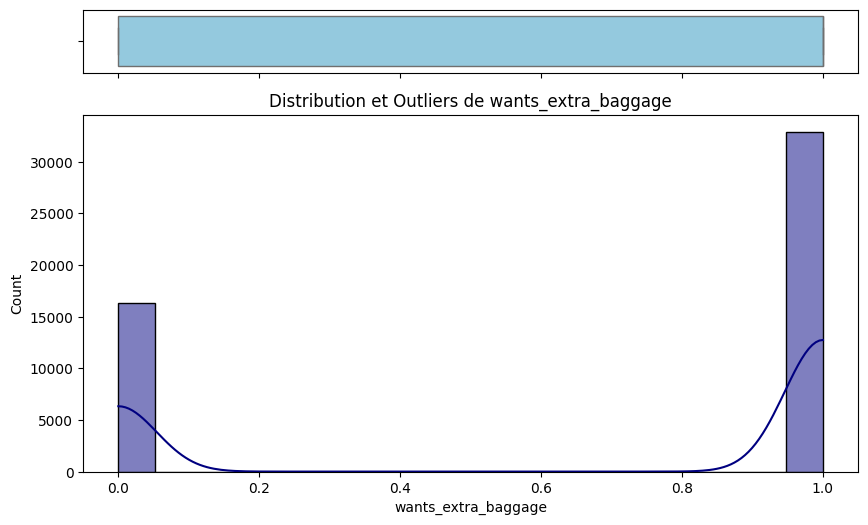

--------------------------------------------------

=== ANALYSE NUMÉRIQUE : WANTS_PREFERRED_SEAT ===
count    49281.000000
mean         0.295631
std          0.456331
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: wants_preferred_seat, dtype: float64
Asymétrie (Skewness) : 0.90
Valeurs manquantes : 0


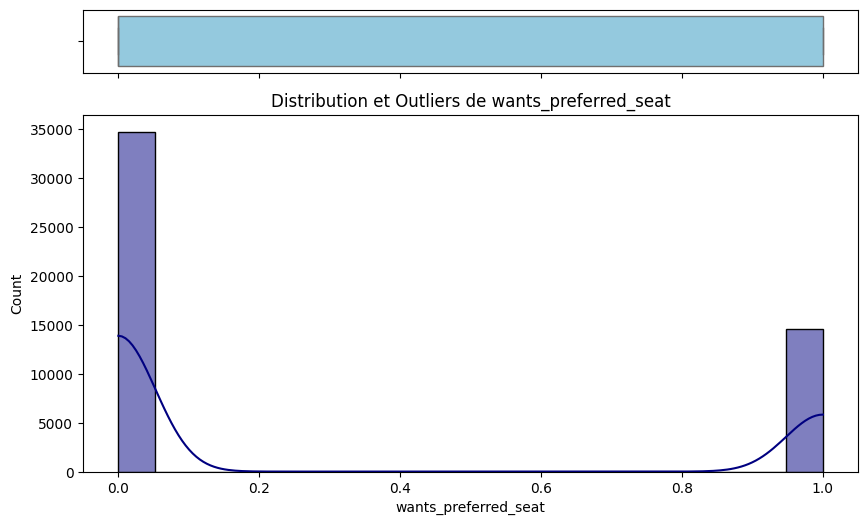

--------------------------------------------------

=== ANALYSE NUMÉRIQUE : WANTS_IN_FLIGHT_MEALS ===
count    49281.000000
mean         0.426635
std          0.494593
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: wants_in_flight_meals, dtype: float64
Asymétrie (Skewness) : 0.30
Valeurs manquantes : 0


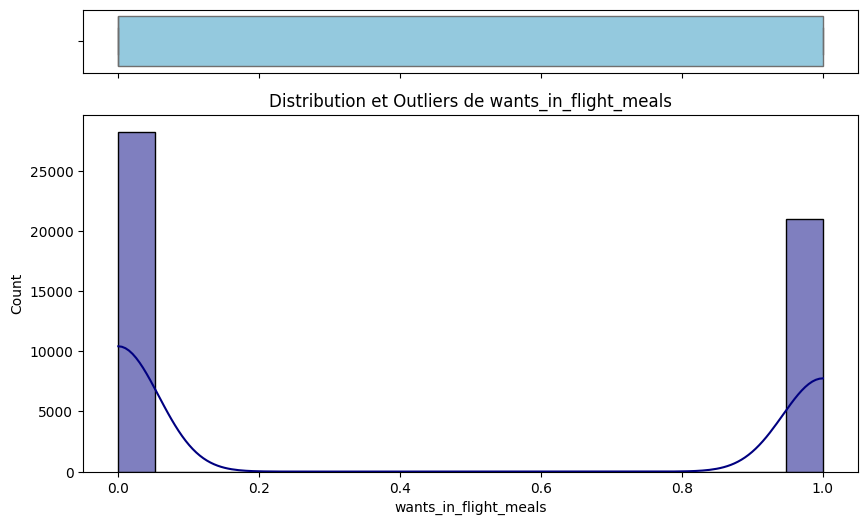

--------------------------------------------------

=== ANALYSE NUMÉRIQUE : FLIGHT_DURATION ===
count    49281.000000
mean         7.279974
std          1.496390
min          4.670000
25%          5.620000
50%          7.570000
75%          8.830000
max          9.500000
Name: flight_duration, dtype: float64
Asymétrie (Skewness) : -0.36
Valeurs manquantes : 0


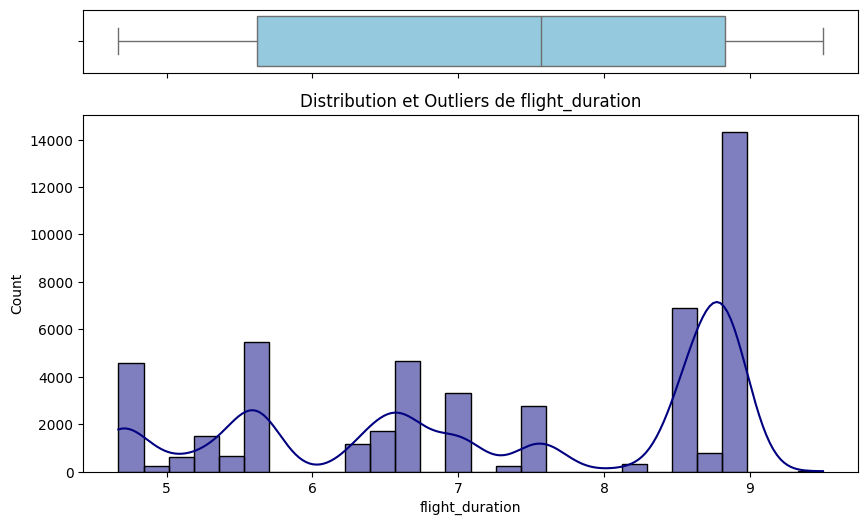

--------------------------------------------------

=== ANALYSE NUMÉRIQUE : BOOKING_COMPLETE ===
count    49281.000000
mean         0.149977
std          0.357052
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: booking_complete, dtype: float64
Asymétrie (Skewness) : 1.96
Valeurs manquantes : 0


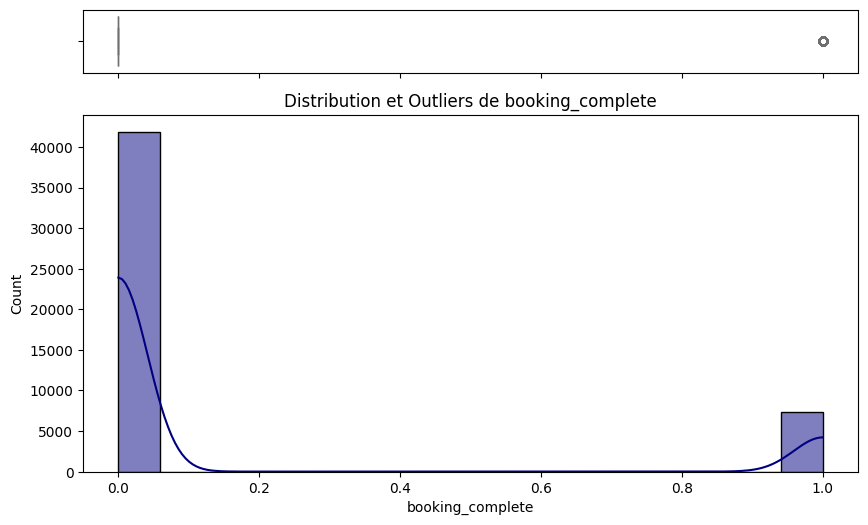

--------------------------------------------------


In [ ]:
analyse_auto_numerique(df)

In [ ]:
df = df[df['length_of_stay']<365]


In [ ]:
df.booking_complete = df.booking_complete.astype("object")
df.wants_extra_baggage = df.wants_extra_baggage.astype("object")
df.wants_in_flight_meals = df.wants_in_flight_meals.astype("object")
df.wants_preferred_seat = df.wants_preferred_seat.astype("object")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49252 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49252 non-null  int64  
 1   sales_channel          49252 non-null  object 
 2   trip_type              49252 non-null  object 
 3   purchase_lead          49252 non-null  int64  
 4   length_of_stay         49252 non-null  int64  
 5   flight_hour            49252 non-null  int64  
 6   flight_day             49252 non-null  object 
 7   route                  49252 non-null  object 
 8   booking_origin         49252 non-null  object 
 9   wants_extra_baggage    49252 non-null  object 
 10  wants_preferred_seat   49252 non-null  object 
 11  wants_in_flight_meals  49252 non-null  object 
 12  flight_duration        49252 non-null  float64
 13  booking_complete       49252 non-null  object 
dtypes: float64(1), int64(4), object(9)
memory usage: 5.6+ MB


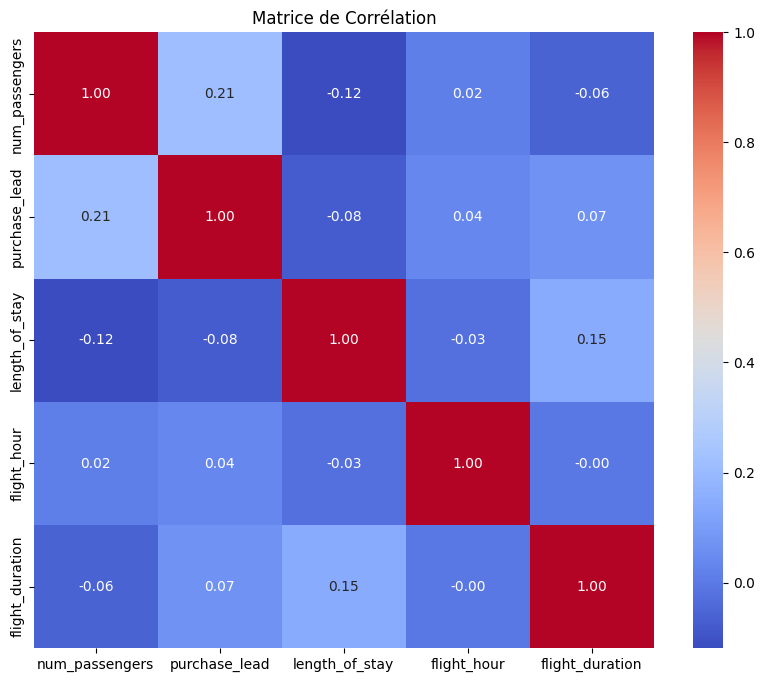

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de Corrélation")
plt.show()

# Preprocessing

Variables to be removed:

trip_type

flight_day

sales_channel

time_of_day

flight_hour

route

wants_preferred_seat

In [ ]:
df['departure_city'] = df['route'].apply(lambda x: x[:3])
df['arrival_city'] = df['route'].apply(lambda x: x[3:])

In [ ]:
df_model = df.drop(['trip_type', 'flight_day', 'sales_channel', 'flight_hour',
               'route', 'wants_preferred_seat'], axis=1)

In [ ]:
from   sklearn.pipeline import make_pipeline
from   sklearn.compose import make_column_transformer
from   sklearn.preprocessing import OrdinalEncoder, StandardScaler , RobustScaler

In [ ]:
X = df_model.drop("booking_complete", axis=1)
y = df_model["booking_complete"].astype(int)

In [ ]:
column_num = X.select_dtypes(include=["number"]).columns
column_cat = X.select_dtypes(include=["object"]).columns


In [ ]:
column_num

Index(['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_duration'], dtype='object')

In [ ]:
column_cat

Index(['booking_origin', 'wants_extra_baggage', 'wants_in_flight_meals',
       'departure_city', 'arrival_city'],
      dtype='object')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01, columns=None, other_label='Other'):
        self.threshold = threshold
        self.columns = columns
        self.other_label = other_label
        self.keep_dict_ = {}

    def fit(self, X, y=None):
        # On s'assure que X est un DataFrame pour le fit
        for col in self.columns:
            freqs = X[col].value_counts(normalize=True)
            self.keep_dict_[col] = freqs[freqs >= self.threshold].index.tolist()
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = X_copy[col].where(X_copy[col].isin(self.keep_dict_[col]), self.other_label)
        return X_copy

    # This method is needed for ColumnTransformer's set_output(transform="pandas") to work
    # for custom transformers that don't internally handle it.
    def set_output(self, *, transform=None):
        return self

    # Cette méthode permet à set_output de fonctionner
    def get_feature_names_out(self, input_features=None):
        return input_features

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

# 1. Définir les colonnes
cols_a_regrouper = ['departure_city', 'arrival_city','booking_origin']
cols_simples = ['wants_extra_baggage', 'wants_in_flight_meals']

# 2. Créer le sous-pipeline catégoriel
cat_pipeline = make_pipeline(
    # Étape A : Regroupement (Seuil à 1% par exemple)
    RareCategoryGrouper(threshold=0.01, columns=cols_a_regrouper),
    # Étape B : Encodage (maintenant il y aura beaucoup moins de colonnes !)
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)
num_pipeline = make_pipeline(
    StandardScaler()
)

# 3. Assembler le tout dans le ColumnTransformer
data_pipeline = make_column_transformer(
    (num_pipeline, column_num),
    (cat_pipeline, cols_a_regrouper + cols_simples),
    remainder="drop"
)


In [ ]:

# Utilisation
data_pipeline.set_output(transform="pandas")
X_prepared = data_pipeline.fit_transform(X)

In [ ]:
X_prepared

,pipeline-1__num_passengers,pipeline-1__purchase_lead,pipeline-1__length_of_stay,pipeline-1__flight_duration,pipeline-2__departure_city_Akl,pipeline-2__departure_city_Bki,pipeline-2__departure_city_Cgk,pipeline-2__departure_city_Cmb,pipeline-2__departure_city_Cnx,pipeline-2__departure_city_Cok,...,pipeline-2__booking_origin_New zealand,pipeline-2__booking_origin_Other,pipeline-2__booking_origin_Singapore,pipeline-2__booking_origin_South korea,pipeline-2__booking_origin_Taiwan,pipeline-2__booking_origin_Thailand,pipeline-2__wants_extra_baggage_0,pipeline-2__wants_extra_baggage_1,pipeline-2__wants_in_flight_meals_0,pipeline-2__wants_in_flight_meals_1
0,0.402826,1.960428,-0.118674,-1.175963,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-0.580715,0.301413,-0.087379,-1.175963,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.402826,1.750286,-0.024789,-1.175963,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.580715,0.124451,0.256868,-1.175963,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.402826,-0.185232,-0.024789,-1.175963,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.402826,-0.638696,-0.525511,-1.109134,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
49996,-0.580715,0.290353,-0.525511,-1.109134,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
49997,-0.580715,-0.671876,-0.525511,-1.109134,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
49998,-0.580715,-0.771417,-0.525511,-1.109134,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
y_pred = rf.predict(X_test)

# Calculate predicted probabilities for class 1
#Crucial pour le score AUC-ROC. Plus le score est proche de 1,
#plus le modèle est sûr que le client va réserver.
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Generate classification report
classification_rep = classification_report(y_test, y_pred)

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'AUC-ROC Score: {roc_auc:.2f}')
print('Confusion Matrix:\n', confusion)
print('Classification Report:\n', classification_rep)

Accuracy: 0.8320
AUC-ROC Score: 0.74
Confusion Matrix:
 [[7899  497]
 [1158  297]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91      8396
           1       0.37      0.20      0.26      1455

    accuracy                           0.83      9851
   macro avg       0.62      0.57      0.58      9851
weighted avg       0.80      0.83      0.81      9851



* la précision de notre modèle à 83.67% est trompeuse car Si 83% des lignes sont des "0", un modèle très bête qui prédirait "0" pour tout le monde aurait 83% d'accuracy sans avoir rien appris.
* mon AUC ROC de 0.74 signifi que mon modele distingue les classe de maniere correcte mais il y a des amelioration possible à faire
* Le rapport indique une précision et un rappel plus faibles pour la classe minoritaire (booking completed). Concrètement :

Le Rappel (Recall) faible : Signifie que ton modèle "rate" beaucoup de clients qui vont pourtant réserver. Tu as beaucoup de Faux Négatifs.

La Précision faible : Signifie que quand le modèle prédit une vente, il se trompe souvent. Tu as des Faux Positifs.

Vrais Négatifs (Haut-Gauche) : On a prédit "Non" et c'était "Non". (Bien)

Vrais Positifs (Bas-Droite) : On a prédit "Oui" et c'était "Oui". (Bien)

Faux Positifs (Haut-Droite) : On a prédit "Oui" mais c'était "Non". (Le client n'achète pas).

Faux Négatifs (Bas-Gauche) : On a prédit "Non" mais c'était "Oui". (Vente ratée).

#validation croisées

In [ ]:
from sklearn.model_selection import cross_val_score

# 1. On utilise le pipeline complet (préparation + modèle)
pipeline_complet = make_pipeline(data_pipeline, rf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. On lance la validation croisée sur le dataset complet avant le split
# cv=5 signifie qu'on va découper et tester 5 fois
scores = cross_val_score(pipeline_complet, X_train, y_train, cv=5, scoring='roc_auc')

print(f"Scores AUC-ROC par pli : {scores}")
print(f"Moyenne AUC-ROC : {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

KeyboardInterrupt: 

#GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Créer le pipeline complet (Préparation + Modèle)
full_pipeline = Pipeline([
    ('preprocessor', data_pipeline),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# 2. Définir la grille de paramètres à tester
# Note : on utilise 'classifier__' pour cibler les paramètres du RandomForest
param_grid = {
    'classifier__max_depth': [10, 20, None],
    'classifier__n_estimators': [100, 200],
    'classifier__min_samples_split': [2, 5]
}

# 3. Configurer le GridSearch
# On utilise scoring='roc_auc' car c'est votre métrique cible
grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# 4. Lancer la recherche (uniquement sur le Train)
grid_search.fit(X_train, y_train)

# 5. Résultat
print(f"Meilleur score AUC : {grid_search.best_score_}")
print(f"Meilleurs paramètres : {grid_search.best_params_}")

Meilleur score AUC : 0.7729290156283772
Meilleurs paramètres : {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


In [ ]:
best_params = grid_search.best_params_

print(f'Best Hyperparameters: {best_params}')

Best Hyperparameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


In [ ]:
# Clean best_params by removing the 'classifier__' prefix
cleaned_best_params = {key.replace('classifier__', ''): value for key, value in best_params.items()}

final_pipeline = Pipeline([
    ('preprocessor', data_pipeline),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', **cleaned_best_params))
])

final_pipeline.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = final_pipeline.predict(X_test)
y_pred_prob = final_pipeline.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
# Print the evaluation metrics
print(f'Accuracy with Best Model: {accuracy:.4f}')
print(f'AUC-ROC Score: {roc_auc:.2f}')
print('Confusion Matrix:\n', confusion)
print('Classification Report:\n', classification_rep)

Accuracy with Best Model: 0.7791
AUC-ROC Score: 0.77
Confusion Matrix:
 [[6914 1482]
 [ 694  761]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86      8396
           1       0.34      0.52      0.41      1455

    accuracy                           0.78      9851
   macro avg       0.62      0.67      0.64      9851
weighted avg       0.82      0.78      0.80      9851



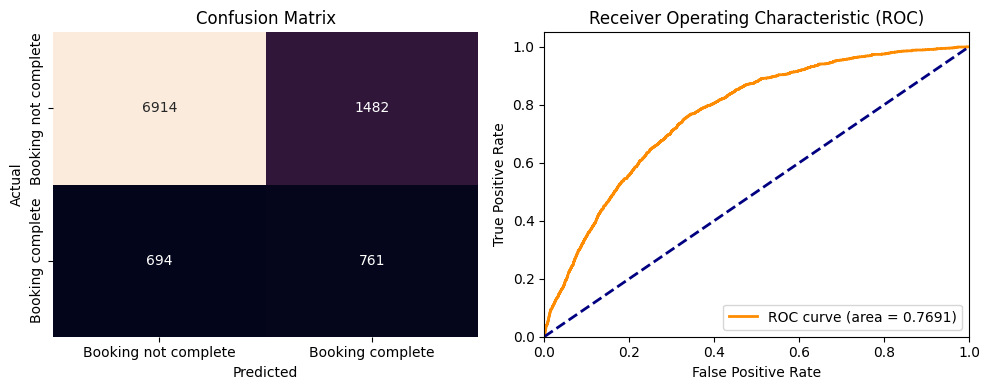

In [ ]:
# Plot confusion matrix and ROC curve

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot Confusion Matrix
sns.heatmap(confusion, annot=True, fmt='d', cbar=False, ax=ax1)

# Customize the Confusion Matrix plot
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(['Booking not complete', 'Booking complete'])
ax1.set_yticklabels(['Booking not complete', 'Booking complete'])

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic (ROC)')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

Ces schémas confirment que mon modèle est robuste mais prudent. Il ne devine pas tout parfaitement, mais il sépare assez bien les comportements pour être utile commercialement. Par exemple, je pourrais utiliser la courbe ROC pour décider d'un seuil de probabilité plus bas (ex: 0.3 au lieu de 0.5) afin de capturer plus de "Vrais Positifs" au prix de quelques "Faux Positifs" supplémentaires.

In [ ]:
X_prepared

,pipeline-1__num_passengers,pipeline-1__purchase_lead,pipeline-1__length_of_stay,pipeline-1__flight_duration,pipeline-2__departure_city_Akl,pipeline-2__departure_city_Bki,pipeline-2__departure_city_Cgk,pipeline-2__departure_city_Cmb,pipeline-2__departure_city_Cnx,pipeline-2__departure_city_Cok,...,pipeline-2__booking_origin_New zealand,pipeline-2__booking_origin_Other,pipeline-2__booking_origin_Singapore,pipeline-2__booking_origin_South korea,pipeline-2__booking_origin_Taiwan,pipeline-2__booking_origin_Thailand,pipeline-2__wants_extra_baggage_0,pipeline-2__wants_extra_baggage_1,pipeline-2__wants_in_flight_meals_0,pipeline-2__wants_in_flight_meals_1
0,0.402826,1.960428,-0.118674,-1.175963,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-0.580715,0.301413,-0.087379,-1.175963,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.402826,1.750286,-0.024789,-1.175963,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.580715,0.124451,0.256868,-1.175963,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.402826,-0.185232,-0.024789,-1.175963,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.402826,-0.638696,-0.525511,-1.109134,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
49996,-0.580715,0.290353,-0.525511,-1.109134,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
49997,-0.580715,-0.671876,-0.525511,-1.109134,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
49998,-0.580715,-0.771417,-0.525511,-1.109134,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


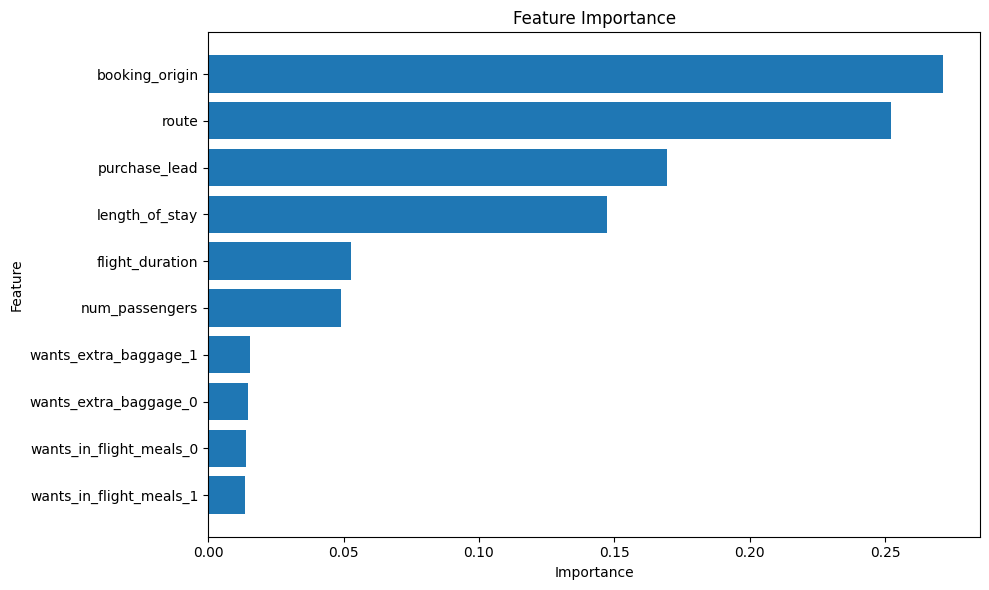

In [ ]:
# Extract importance of each feature from the model
feature_importances = final_pipeline.named_steps['classifier'].feature_importances_
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame to associate importances with column names
importance_df = pd.DataFrame({'Column': feature_names, 'Importance': feature_importances})

# Calculate cumulative sum of importance for original categorical groups
booking_origin_cumulative = importance_df[importance_df['Column'].str.contains('booking_origin_')]['Importance'].sum()
arrival_city_cumulative = importance_df[importance_df['Column'].str.contains('arrival_city_')]['Importance'].sum()
departure_city_cumulative = importance_df[importance_df['Column'].str.contains('departure_city_')]['Importance'].sum()

# Extract non-one-hot encoded features (numerical and simple OHE like wants_extra_baggage)
non_ohe_importance_df = importance_df[
    ~importance_df['Column'].str.contains('booking_origin_') &
    ~importance_df['Column'].str.contains('arrival_city_') &
    ~importance_df['Column'].str.contains('departure_city_')
].copy()

# Rename the numerical and simple OHE columns to remove 'pipeline-1__' and 'pipeline-2__' prefixes
non_ohe_importance_df['Column'] = non_ohe_importance_df['Column'].str.replace('pipeline-1__', '')
non_ohe_importance_df['Column'] = non_ohe_importance_df['Column'].str.replace('pipeline-2__', '')

cumulative_importance_df = pd.DataFrame({
    'Column': ['booking_origin', 'route'],
    'Importance': [booking_origin_cumulative, (arrival_city_cumulative + departure_city_cumulative)]
})

# Concatenate non-OHE features with cumulative OHE features
final_importance_df = pd.concat([non_ohe_importance_df, cumulative_importance_df], ignore_index=True)

# Sort by importance in descending order
final_importance_df = final_importance_df.sort_values(by='Importance', ascending=False)

# Plot the most important features
plt.figure(figsize=(10, 6)) # Increased figure size for better readability
plt.barh(final_importance_df['Column'][::-1], final_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

* D'après l'intrigue, il est évident que booking_origin et route sont les caractéristiques les plus importantes, indiquant que l'endroit où une réservation est effectuée et le voyage spécifique qu'elle implique sont primordiaux pour déterminer la probabilité de réalisation de la réservation.
* Des facteurs tels que Purchase_lead et length_of_stay jouent également un rôle important, ce qui suggère que le moment de l'achat et la durée du séjour prévu sont des considérations cruciales pour les clients.
* Moins percutants, mais toujours influents, sont flight_duration, num_passengers, wanted_extra_baggage et wanted_in_flight_meals, qui correspondent aux attentes intuitives concernant les préférences et les choix des clients.


Synthèse de mon projet
Voici le bilan de ton travail :

Performance solide : Mon score AUC-ROC de 0.77 est très satisfaisant pour un premier modèle sur ce type de données.

Équilibre trouvé : Grâce à mes ajustements, j' identifies maintenant 52% des acheteurs réels (Recall), ce qui est une base de travail sérieuse pour une stratégie marketing.

Pipeline robuste : mon utilisation d'un ColumnTransformer avec un RareCategoryGrouper personnalisé rend mon modèle prêt à l'emploi pour de nouvelles données via un CLI